In [2]:
import pandas as pd
import matplotlib as plt

In [3]:
car = pd.read_csv('data/train.csv')
car_test = pd.read_csv('data/test.csv')

In [4]:
car.tail()

# tail을 통해 total record 개수를 확인하고, 누락된 data가 있는지 확인

,Id,Model,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,Fuel_Type,HP,Met_Color,...,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Parking_Assistant,Tow_Bar
1014,1434,TOYOTA Corolla 1.3 16V HATCHB LINEA TERRA AUT3...,8950,71,10,1998,29000,Petrol,86,1,...,0,1,0,0,0,1,0,0,0,0
1015,1438,TOYOTA Corolla 1.3 16V HATCHB G6 2/3-Doors,7500,69,12,1998,20544,Petrol,86,1,...,1,1,0,1,1,1,0,0,0,0
1016,1440,TOYOTA Corolla 1.3 16V HATCHB LINEA TERRA 2/3-...,8500,71,10,1998,17016,Petrol,86,0,...,0,1,0,0,0,1,0,0,0,0
1017,1441,TOYOTA Corolla 1.3 16V HATCHB LINEA TERRA 2/3-...,7250,70,11,1998,16916,Petrol,86,1,...,0,0,0,0,0,1,0,0,0,0
1018,1442,TOYOTA Corolla 1.6 LB LINEA TERRA 4/5-Doors,6950,76,5,1998,1,Petrol,110,0,...,0,1,0,0,0,0,0,0,0,0


In [5]:
# 독립변수와 종속변수 분리
cary = car.iloc[:, :3]
carx = car.iloc[:, 3:]

cary_test = car_test.iloc[:, :2]
carx_test = car_test.iloc[:, 2:]

# Id, Model, Price를 cary로,
# 나머지 변수들을 carx로 분리

In [6]:
carx.tail()

# tail로 carx를 호출해 잘 분리되었는지 확인

,Age_08_04,Mfg_Month,Mfg_Year,KM,Fuel_Type,HP,Met_Color,Color,Automatic,CC,...,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Parking_Assistant,Tow_Bar
1014,71,10,1998,29000,Petrol,86,1,Blue,1,1300,...,0,1,0,0,0,1,0,0,0,0
1015,69,12,1998,20544,Petrol,86,1,Blue,0,1300,...,1,1,0,1,1,1,0,0,0,0
1016,71,10,1998,17016,Petrol,86,0,Blue,0,1300,...,0,1,0,0,0,1,0,0,0,0
1017,70,11,1998,16916,Petrol,86,1,Grey,0,1300,...,0,0,0,0,0,1,0,0,0,0
1018,76,5,1998,1,Petrol,110,0,Green,0,1600,...,0,1,0,0,0,0,0,0,0,0


In [7]:
# carx의 기술통계량 확인

carx.describe()

,Age_08_04,Mfg_Month,Mfg_Year,KM,HP,Met_Color,Automatic,CC,Doors,Cylinders,...,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Parking_Assistant,Tow_Bar
count,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.0,...,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000
mean,56.041217,5.480864,1999.623160,68177.927380,101.479882,0.669284,0.056919,1579.582924,4.044161,4.0,...,0.567223,0.974485,0.142296,0.261040,0.312071,0.771344,0.196271,0.142296,0.002944,0.278705
std,18.615283,3.304515,1.548589,37966.031948,14.811333,0.470702,0.231801,488.566949,0.954265,0.0,...,0.495704,0.157761,0.349525,0.439417,0.463566,0.420173,0.397371,0.349525,0.054206,0.448582
min,1.000000,1.000000,1998.000000,1.000000,69.000000,0.000000,0.000000,1300.000000,2.000000,4.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,44.000000,3.000000,1998.000000,41567.500000,86.000000,0.000000,0.000000,1400.000000,3.000000,4.0,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,61.000000,5.000000,1999.000000,62280.000000,110.000000,1.000000,0.000000,1600.000000,4.000000,4.0,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,70.000000,8.000000,2001.000000,86467.500000,110.000000,1.000000,0.000000,1600.000000,5.000000,4.0,...,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,80.000000,12.000000,2004.000000,243000.000000,192.000000,1.000000,1.000000,16000.000000,5.000000,4.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


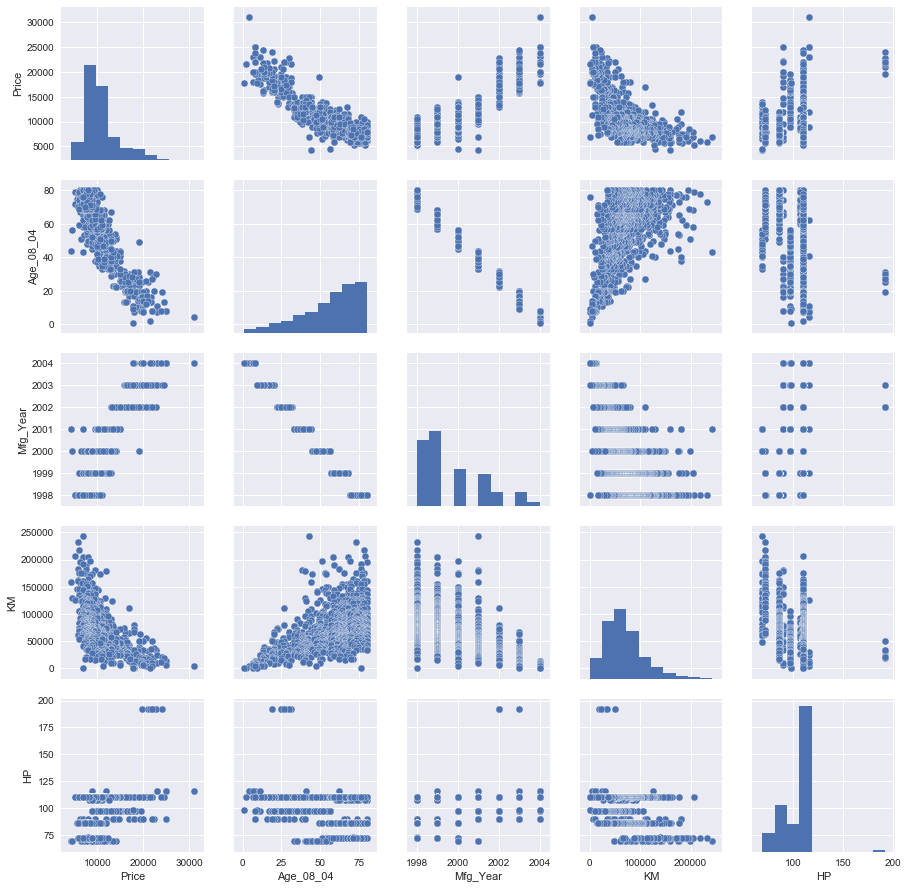

In [8]:
# 양적변수로 판단되는 변수들과 Price를 scatter plot으로 표현
# 상관관계가 있는지 plot을 통해 확인

import seaborn as sns
%matplotlib inline
sns.pairplot(pd.concat([cary.Price, carx[['Age_08_04', 'Mfg_Year', 'KM', 'HP']]], axis = 1))